# Single-Station HVSR Analysis with Real Data

This notebook demonstrates HVSR (Horizontal-to-Vertical Spectral Ratio) analysis using real seismic data from a single station.


## 1. Setup and Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from obspy import read, Stream
from obspy.core import UTCDateTime
import tqdm

import sys
sys.path.append('..')

from hvsr_lite.core import compute_hvsr, HVSRResult
from hvsr_lite.utils import stream_to_dict

plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("All imports successful!")

All imports successful!


## 2. Load Real MiniSEED Data

In [2]:
data_dir = Path('/Users/shihao/Research/CSM/Projects/BHP/BHP_OCELOT/SEISMIC/Data')

station_name = '453000225' 
date_str = '2022.07.30.00.00.00.000'

components = {'E': 'east', 'N': 'north', 'Z': 'vertical'}
streams = {}

for comp_code, comp_name in components.items():
    filename = f"{station_name}..0.20.{date_str}.{comp_code}_RESPREMOVED.miniseed"
    filepath = data_dir / filename
    
    if filepath.exists():
        st = read(str(filepath))
        streams[comp_name] = st
    else:
        print(f"File not found: {filename}")

st_all = Stream()
for comp_name in ['north', 'east', 'vertical']:
    if comp_name in streams:
        st_all += streams[comp_name]


## 3. Data Preprocessing


Preprocessing steps:
1. Removing mean...
2. Removing linear trend...
3. Applying taper...
4. Applying bandpass filter (0.1-20 Hz)...


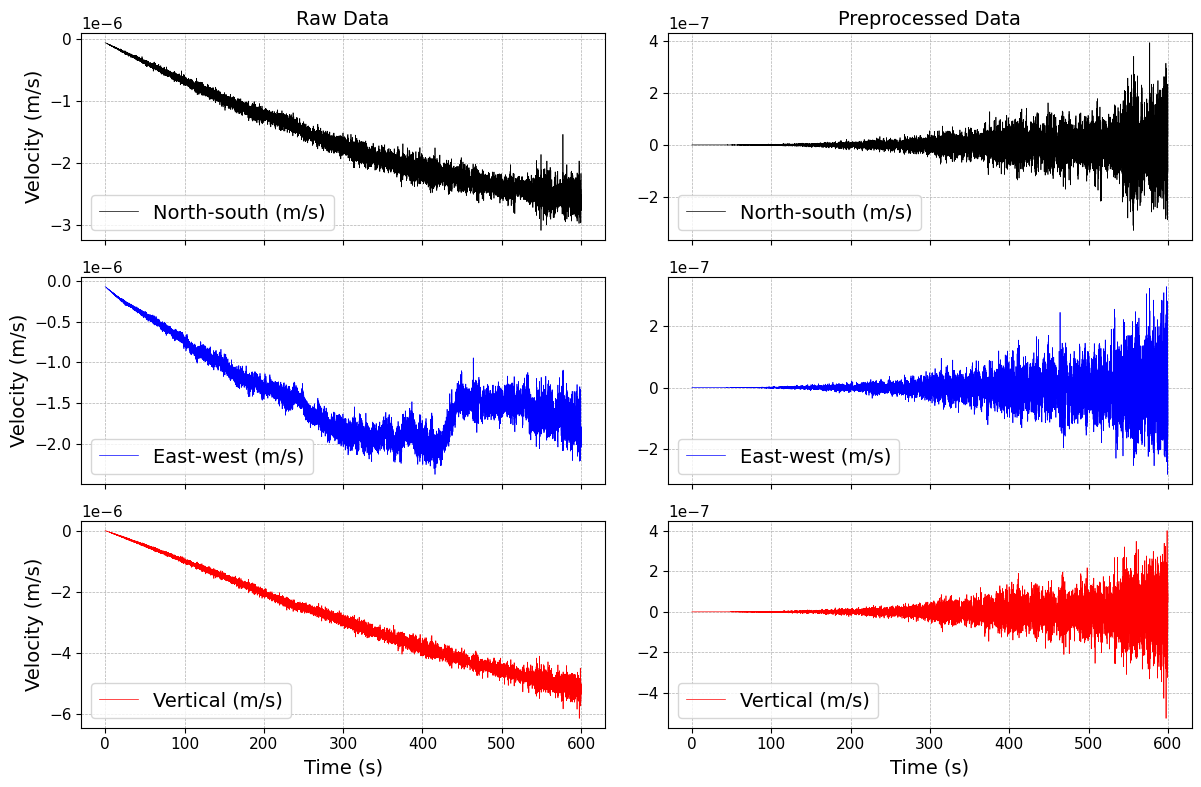

In [5]:
st_processed = st_all.copy()

print("Preprocessing steps:")
print("1. Removing mean...")
st_processed.detrend(type='demean')

print("2. Removing linear trend...")
st_processed.detrend(type='linear')

print("3. Applying taper...")
st_processed.taper(max_percentage=0.01, type='cosine')

print("4. Applying bandpass filter (0.1-20 Hz)...")
st_processed.filter('bandpass', freqmin=0.1, freqmax=20.0, corners=4, zerophase=True)


fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex='col')
legend_names = ['North-south (m/s)', 'East-west (m/s)', 'Vertical (m/s)']
colors = ['k', 'b', 'r']

duration = 600  # 10 minutes in seconds
sampling_rate = st_all[0].stats.sampling_rate
n_samples = int(duration * sampling_rate)

for i, (tr_raw, tr_proc, color) in enumerate(zip(st_all, st_processed, colors)):
    time = np.arange(n_samples) / sampling_rate
    
    # Raw data
    axes[i, 0].plot(time, tr_raw.data[:n_samples], color=color, linewidth=0.5,label=legend_names[i])
    axes[i, 0].set_ylabel('Velocity (m/s)', fontsize=14)
    axes[i, 0].grid(True,linestyle='--',linewidth=0.5)
    axes[i, 0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axes[i, 0].legend(loc='lower left', fontsize=14)
    if i == 0:
        axes[i, 0].set_title('Raw Data', fontsize=14)
    
    # Processed data
    axes[i, 1].plot(time, tr_proc.data[:n_samples], color=color, linewidth=0.5,label=legend_names[i])
    axes[i, 1].grid(True,linestyle='--',linewidth=0.5)
    axes[i, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axes[i, 1].legend(loc='lower left', fontsize=14)
    if i == 0:
        axes[i, 1].set_title('Preprocessed Data', fontsize=14)

axes[-1, 0].set_xlabel('Time (s)', fontsize=14)
axes[-1, 1].set_xlabel('Time (s)', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Extract Time Window for HVSR

In [6]:
start_time = st_processed[0].stats.starttime  
end_time = start_time + 2 * 3600  # 2 hours duration

print(f"Extracting time window for HVSR:")
print(f"  Start: {start_time}")
print(f"  End: {end_time}")
print(f"  Duration: {(end_time - start_time)/60:.0f} minutes")
print(f"  This will allow for 300s windows with good overlap")

# Trim to selected window
st_hvsr = st_processed.copy()
st_hvsr.trim(starttime=start_time, endtime=end_time)

print(f"\nWindow extracted: {st_hvsr[0].stats.npts} samples per component")

hvsr_data = stream_to_dict(st_hvsr)
print(f"\nConverted to dictionary format")
print(f"  Keys: {list(hvsr_data.keys())}")
print(f"  Sampling rate: {hvsr_data['sampling_rate']} Hz")

Extracting time window for HVSR:
  Start: 2022-07-30T00:00:00.000000Z
  End: 2022-07-30T02:00:00.000000Z
  Duration: 120 minutes
  This will allow for 300s windows with good overlap

Window extracted: 1800001 samples per component

Converted to dictionary format
  Keys: ['sampling_rate', 'north', 'east', 'vertical']
  Sampling rate: 250.0 Hz


## 7. Compute HVSR

In [7]:
# Set parameters
window_length = 50.0  # 30-second windows
overlap = 0.5
smoothing_window = 4
ko_bandwidth = 50.0
fmin = 0.1
fmax = 20.0

print("HVSR Processing Parameters:")
print(f"  Window length: {window_length} seconds")
print(f"  Overlap: {overlap*100:.0f}%")
print(f"  Smoothing window: {smoothing_window} points")

horizontal_components = np.column_stack([hvsr_data['north'], hvsr_data['east']])

# Compute HVSR
print(f"\nComputing HVSR with {window_length}s windows...")

result = compute_hvsr(
    horizontal_data=horizontal_components,
    vertical_data=hvsr_data['vertical'],
    sampling_rate=hvsr_data['sampling_rate'],
    window_length=window_length,
    overlap=overlap,
    smoothing_window=smoothing_window,
    
    stack_method='window_ratio_median',  # Median of per-window ratios
    horizontal_combine='geometric_mean',  # Geometric mean of N-E components
    
    # Smoothing configuration 
    smoothing_method='custom_ko', # Use Konno-Ohmachi Method
    ko_bandwidth=40.0,  # Bandwidth (adjust 20-100 for more/less smoothing)
    
    # Alternative smoothing methods:
    # smoothing_method='custom_ko_smooth',
    # smoothing_method='moving_average',  # Fast, less smooth
    # smoothing_method='konno_ohmachi',  # ObsPy implementation
    
    # Quality control parameters
    sta_lta_ratio_threshold=1.5,
    max_amplitude_threshold=None,
    window_smoothing=False,
    window_smoothing_window=2,
    
    # Frequency domain parameters
    min_frequency=0.2,  # Exclude unreliable low frequencies
    max_frequency=30,
    max_frequency_ratio=0.3,
    frequency_taper=True,
    anti_aliasing_filter=True
)

print(f"\nHVSR computation complete!")



HVSR Processing Parameters:
  Window length: 50.0 seconds
  Overlap: 50%
  Smoothing window: 4 points

Computing HVSR with 50.0s windows...


Processing windows: 100%|██████████| 287/287 [00:01<00:00, 196.62win/s]


259/287 windows (90.2%)
Frequency: 0.22-29.3 Hz
Smoothing: Custom KO (bw=40.0)

HVSR computation complete!


## 8. Identify Peak Frequency

In [8]:
# Find peak frequency and amplitude
freq = result.frequencies
hvsr = result.hvsr_values

# Find peak in frequency range of interest (e.g., 0.5-10 Hz)
freq_mask = (freq >= 0.5) & (freq <= 10.0)
peak_idx = np.argmax(hvsr[freq_mask])
peak_freq = freq[freq_mask][peak_idx]
peak_amp = hvsr[freq_mask][peak_idx]

print("\nHVSR Peak Analysis:")
print("=" * 60)
print(f"Peak frequency (f_0): {peak_freq:.3f} Hz")
print(f"Peak amplitude (A_0): {peak_amp:.2f}")

# Peak clarity: ratio of peak to mean HVSR
mean_hvsr = np.mean(hvsr[freq_mask])
peak_clarity = peak_amp / mean_hvsr
print(f"\nPeak clarity: {peak_clarity:.2f}")

# Peak prominence
baseline = np.median(hvsr[freq_mask])
peak_prominence = peak_amp / baseline
print(f"Peak prominence (vs median): {peak_prominence:.2f}")

if peak_clarity > 2.0:
    print("\nStrong HVSR peak detected!")
elif peak_clarity > 1.5:
    print("\nModerate HVSR peak detected")
else:
    print("\nWeak or unclear HVSR peak")


HVSR Peak Analysis:
Peak frequency (f_0): 1.740 Hz
Peak amplitude (A_0): 6.91

Peak clarity: 5.02
Peak prominence (vs median): 7.58

Strong HVSR peak detected!


## 9. Visualize HVSR Results

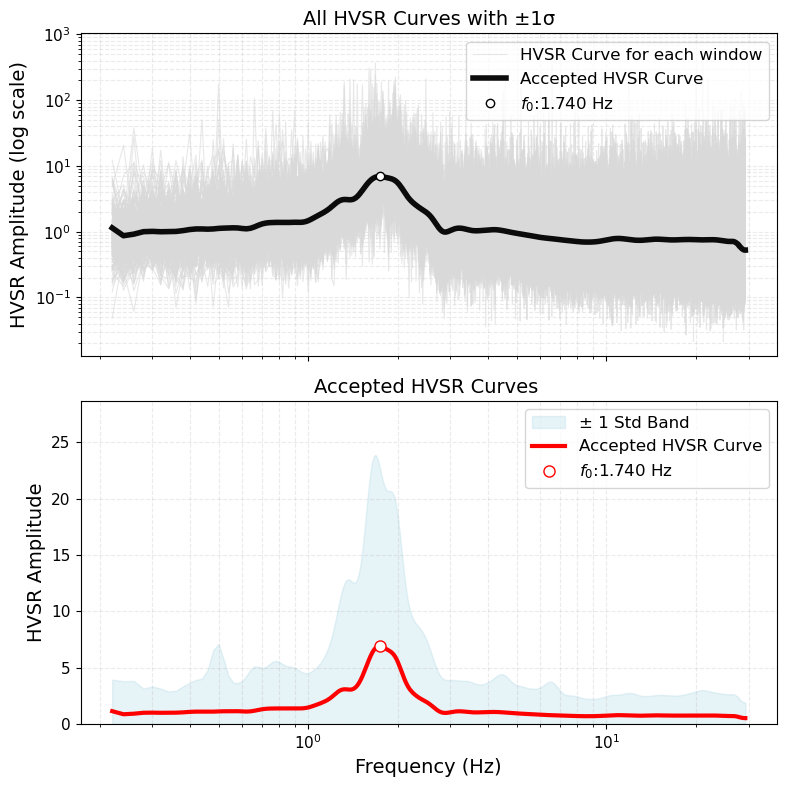

In [9]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

freq = result.frequencies
hvsr_main = result.hvsr_values
hvsr_mean = getattr(result, 'hvsr_mean', None)
hvsr_std  = getattr(result, 'hvsr_std', None)
window_hvsr = getattr(result, 'window_hvsr', None)

if window_hvsr is not None:
    for i in range(window_hvsr.shape[0]):
        if i == 0:
            ax1.plot(freq, window_hvsr[i], color='0.85', linewidth=0.8, alpha=0.6,label='HVSR Curve for each window')
        else:
            ax1.plot(freq, window_hvsr[i], color='0.85', linewidth=0.8, alpha=0.6)

# Accepted/smoothed curve
ax1.plot(freq, hvsr_main, color='k', linewidth=4, alpha=0.95, label='Accepted HVSR Curve')

try:
    ax1.plot(peak_freq, peak_amp, marker='o', markersize=6, color='white', mec='black', linestyle='None', label=fr'$f_0$:{peak_freq:.3f} Hz')
except Exception:
    pass

ax1.set_xscale('log')
ax1.set_yscale('log')  # Use log scale for y-axis to better show all curves
ax1.set_ylabel('HVSR Amplitude (log scale)', fontsize=14)
ax1.set_title('All HVSR Curves with ±1σ', fontsize=14)
ax1.grid(True, which='both', linestyle='--', alpha=0.25)
ax1.legend(loc='upper right', fontsize=12)

if hvsr_mean is not None and hvsr_std is not None:
    # Calculate appropriate y-limits for mean curves
    mean_max = max(hvsr_mean.max(), hvsr_main.max())
    std_max = (hvsr_mean + hvsr_std).max()
    y_max = max(mean_max, std_max) * 1.2
    
    upper = hvsr_mean + hvsr_std
    lower = np.maximum(hvsr_mean - hvsr_std, 0)
    
    ax2.fill_between(freq, lower, upper, color='lightblue', alpha=0.3, label='± 1 Std Band')
    # ax2.plot(freq, upper, 'b--', linewidth=1, label='± 1 Std Bounds')
    # ax2.plot(freq, lower, 'b--', linewidth=1)
    # ax2.plot(freq, hvsr_mean, 'b-', linewidth=2, label='Mean Curve')
    ax2.plot(freq, hvsr_main, 'r-', linewidth=3, label='Accepted HVSR Curve')
    
    try:
        ax2.plot(peak_freq, peak_amp, marker='o', markersize=8, color='white', mec='red', linestyle='None', label=fr'$f_0$:{peak_freq:.3f} Hz')
    except Exception:
        pass
    
    ax2.set_ylim(0, y_max)
else:
    ax2.plot(freq, hvsr_main, 'r-', linewidth=3, label='HVSR Curve')
    try:
        ax2.plot(peak_freq, peak_amp, marker='o', markersize=8, color='white', mec='red', linestyle='None', label=fr'$f_0$:{peak_freq:.3f} Hz')
    except Exception:
        pass

ax2.set_xscale('log')
ax2.set_xlabel('Frequency (Hz)', fontsize=14)
ax2.set_ylabel('HVSR Amplitude', fontsize=14)
ax2.set_title('Accepted HVSR Curves ', fontsize=14)
ax2.grid(True, which='both', linestyle='--', alpha=0.25)
ax2.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()


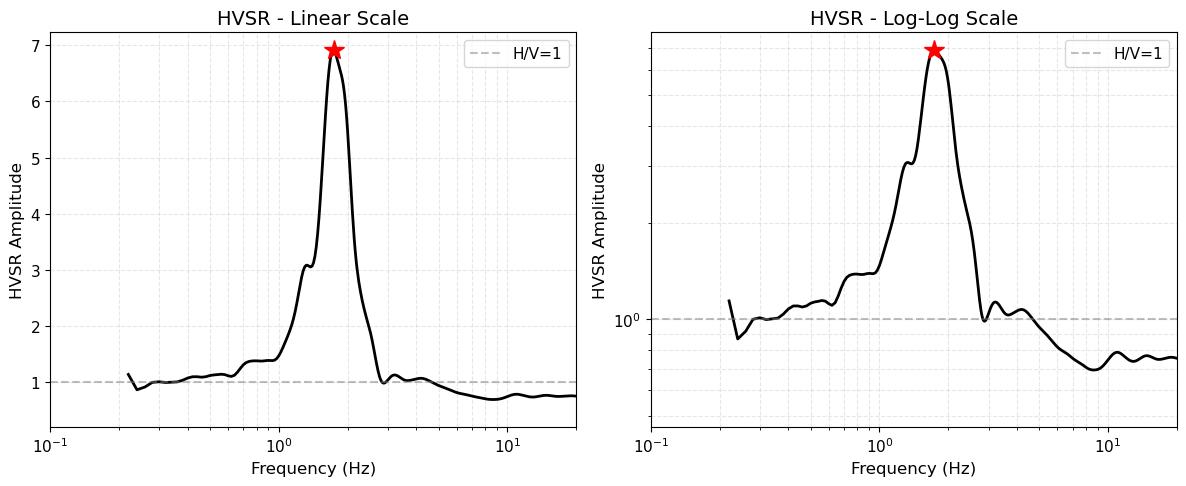

In [10]:
# Additional visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Linear y-axis
ax1.plot(freq, hvsr, 'k-', linewidth=2)
ax1.plot(peak_freq, peak_amp, 'r*', markersize=15)
ax1.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='H/V=1')
ax1.set_xlabel('Frequency (Hz)', fontsize=12)
ax1.set_ylabel('HVSR Amplitude', fontsize=12)
ax1.set_title('HVSR - Linear Scale', fontsize=14)
ax1.set_xscale('log')
ax1.set_xlim(0.1, 20)
ax1.grid(True, alpha=0.3, which='both', linestyle='--')
ax1.legend()

# Log-log scale
ax2.loglog(freq, hvsr, 'k-', linewidth=2)
ax2.plot(peak_freq, peak_amp, 'r*', markersize=15)
ax2.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='H/V=1')
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('HVSR Amplitude', fontsize=12)
ax2.set_title('HVSR - Log-Log Scale', fontsize=14)
ax2.set_xlim(0.1, 20)
ax2.grid(True, alpha=0.3, which='both', linestyle='--')
ax2.legend()

plt.tight_layout()
plt.show()